# Test and Trial on Gaussian Mixture Distribution.

In [1]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions \
    import MultivariateNormalFullCovariance

from nn4post import InferenceBuilder
try:
    from tensorflow.contrib.distributions import Independent
except:
    from nn4post.utils.independent import Independent

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# For reproducibility
SEED = 123456
tf.set_random_seed(SEED)
np.random.seed(SEED)

In [3]:
def make_log_posterior(target_covariance):
    """2-dimensional Gaussian distribution centered at the center."""
    target_covariance = tf.convert_to_tensor(target_covariance)
    
    # -- Gaussian Distribution
    with tf.name_scope('posterior'):

      p = MultivariateNormalFullCovariance(
              loc=[0.0, 0.0],
              covariance_matrix=target_covariance)
    
      def log_posterior(theta):
          return p.log_prob(theta)

    return log_posterior

In [4]:
def shall_stop(loss_values, tolerance, n_means=20):
    """Returns `True` if the relative variance of loss-value in
    `loss_values` becomes smaller than `tolerance`, else `False`.
    The loss-value is smeared by its nearby `n_means` loss-values.
    """
    if len(loss_values) < 2 * n_means:
        return False

    else:
        previous_loss = np.mean(loss_values[-2*n_means:-n_means])
        current_loss = np.mean(loss_values[-n_means:])
        delta_loss = previous_loss - current_loss
        relative_delta_loss = abs( delta_loss / (current_loss + 1e-8) )

        if relative_delta_loss < tolerance:
            return True
        else:
            return False


def test(target_covariance, init_var,
         tolerance=1e-2, n_iters=None, optimizer=None,
         **inference_kwargs):
    """Test on Gaussian mixture distribution as the target.
    
    Args:
        target_covariance: Numpy array.
        init_var: Dictionary with keys: "a", "mu", and "zeta" and
            values numpy arraies.
        XXX
            `n_iters` is more preferable than `tolerance`.
        inference_kwargs: Dictionary, as the kwargs (parameters)
            of `InferenceBuilder.__init__()`.
    
    Returns:
        Dictionary with keys: "loss", "a", "mu", and "zeta", and
        values the values at each iteration, collected in a list.
    """

    tf.reset_default_graph()

    log_p = make_log_posterior(target_covariance)

    n_c, n_d = init_var['mu'].shape
    ib = InferenceBuilder(n_c, n_d, log_p, **inference_kwargs)
    
    a = tf.Variable(init_var['a'], dtype='float32')
    mu = tf.Variable(init_var['mu'], dtype='float32')
    zeta = tf.Variable(init_var['zeta'], dtype='float32')
    loss, gradients = ib.make_loss_and_gradients(a, mu, zeta)
    
    if optimizer is None:
        optimizer = tf.train.RMSPropOptimizer(0.05)
        #optimizer = tf.train.AdamOptimizer(0.005)
    train_op = optimizer.apply_gradients(gradients)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        test_result = {'loss': [], 'a': [], 'mu': [], 'zeta': []}
        step = 0
            
        def iter_body():
            
            nonlocal step

            _, loss_val, a_val, mu_val, zeta_val \
                = sess.run([train_op, loss, a, mu, zeta])

            test_result['loss'].append(loss_val)
            test_result['a'].append(a_val)
            test_result['mu'].append(mu_val)
            test_result['zeta'].append(zeta_val)
            
            step += 1
            if (step+1) % 100 == 0:
                print(step, loss_val)

        if n_iters:
            for i in range(n_iters):
                iter_body()
                
        else:
            while not shall_stop(test_result['loss'], tolerance):
                iter_body()
                
    return test_result

In [5]:
# Helpers

def softplus(x, limit=10.):
    return np.where(x<limit, np.log(1. + np.exp(x)), x)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def plot_trajectory(trajectory, i=0, j=1):
    """Plot the 2D projection of the trajectory `trajectory`.
    
    Args:
        trajectory: List of 2D numpy array.
        i: Integer, as the x-axis to be plotted, optional.
        j: Integer, as the y-axis to be plotted, optional.
    """
    n_points = len(trajectory)
    x = [_[i] for _ in trajectory]
    y = [_[j] for _ in trajectory]
    delta_x = [x[i+1] - x[i] for i in range(n_points-1)]
    delta_y = [y[i+1] - y[i] for i in range(n_points-1)]
    plt.quiver(x, y, delta_x, delta_y)

In [11]:
def display(test_result):
    """For visualization."""
    
    print('Final loss:', np.mean(test_result['loss'][-20:]))
    
    for i in range(n_c):

        mu_trajectory = [_[i,:] for _ in test_result['mu']]
        plot_trajectory(mu_trajectory)
        plt.show()
        
        sigma_trajectory = [softplus(_[i,:]) for _ in test_result['zeta']]
        plot_trajectory(sigma_trajectory)
        plt.show()
        
        c = [softmax(_) for _ in test_result['a']]
        plt.plot([_[i] for _ in c])
        plt.show()

        print('--------------')

In [7]:
n_d = 2
target_covariance = np.array([[1, 1/2], [1/2, 1]])
target_covariance = target_covariance.astype('float32')

n_c = 5
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 30., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 2000

In [8]:
%%time

test_result_1_rmsprop = test(
    target_covariance, init_var, tolerance=tolerance,
    n_iters=n_iters, beta=1.0)

99 1.6345277
199 0.33187938
299 0.34351534
399 0.2601633
499 0.28358012
599 0.22244652
699 0.25099164
799 0.02555154
899 0.02229564
999 0.015034121
1099 0.0059554107
1199 0.0032300462
1299 -0.008904219
1399 0.009796381
1499 0.0005328655
1599 0.0031352043
1699 0.0072569847
1799 0.0054917336
1899 0.0069639683
1999 -0.0046384335
CPU times: user 38min 35s, sys: 6min 13s, total: 44min 49s
Wall time: 14min 28s


Final loss: 0.0063151955


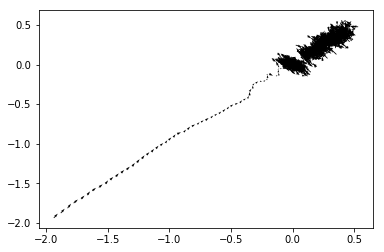

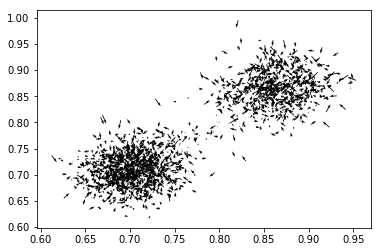

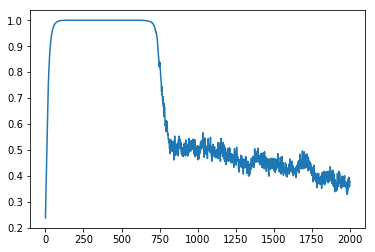

--------------


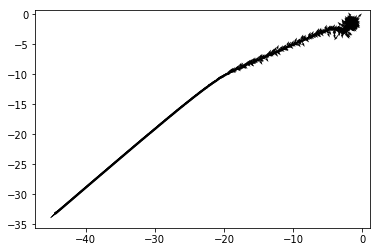

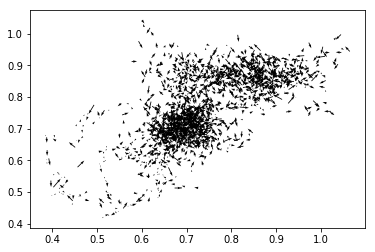

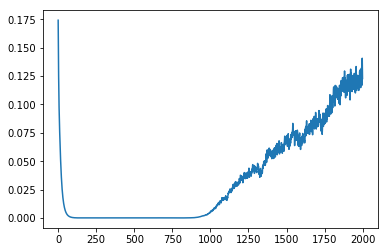

--------------


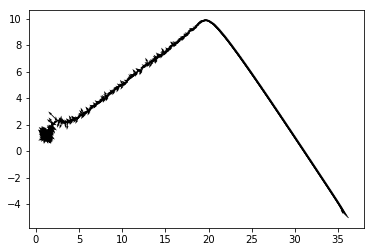

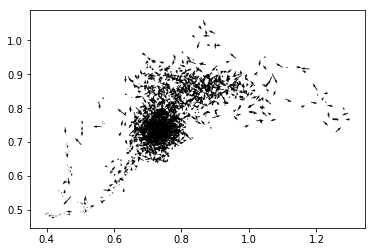

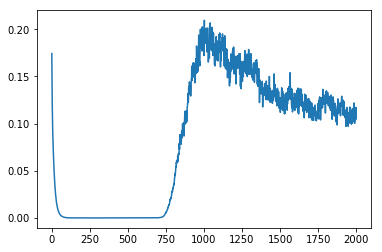

--------------


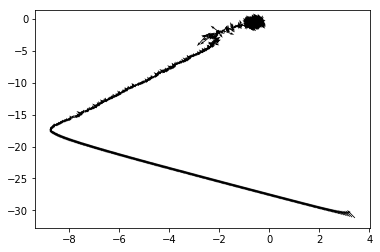

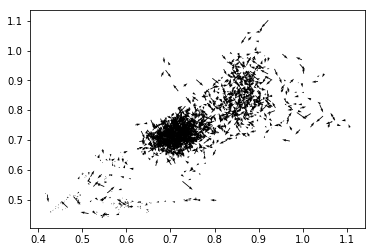

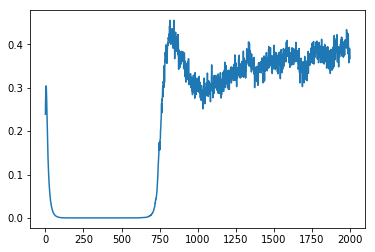

--------------


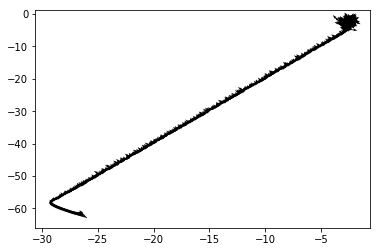

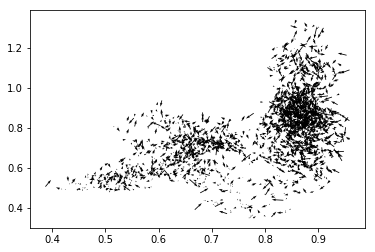

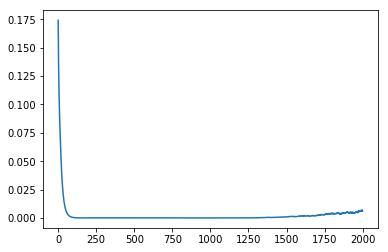

--------------


In [12]:
display(test_result_1_rmsprop)

In [15]:
%%time

test_result_1 = test(target_covariance, init_var, tolerance=tolerance,
                     n_iters=n_iters, beta=1.0,
                     optimizer=tf.train.GradientDescentOptimizer(0.001))

99 nan
199 nan
299 nan
399 nan


KeyboardInterrupt: 